In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Function
import numpy as np
import scipy.linalg
import csv
import attn_modules as attn
import ukf_modules as ukf_
import odometry as odom
import gc
import torch.optim as optim

import matplotlib.pyplot as plt

/home/jovyan/.conda/envs/foo/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
"""
Utility functions
"""


def quat2eul(qw,qx,qy,qz):
    
    # roll (x-axis rotation)
    sinr_cosp = 2 * (qw * qx + qy * qz);
    cosr_cosp = 1 - 2 * (qx * qx + qy * qy);
    roll = np.arctan2(sinr_cosp, cosr_cosp);

    # pitch (y-axis rotation)
    sinp = 2 * (qw * qy - qz * qx);
    #if (abs(sinp) >= 1):
     #   pitch = copysign(M_PI / 2, sinp) # use 90 degrees if out of range
    #else:
    pitch = np.arcsin(sinp);

    # yaw (z-axis rotation)
    siny_cosp = 2 * (qw * qz + qx * qy);
    cosy_cosp = 1 - 2 * (qy * qy + qz * qz);
    yaw = np.arctan2(siny_cosp, cosy_cosp);

    return roll, pitch, yaw


def c(x):
    return torch.cos(x.cuda())
def s(x):
    return torch.sin(x.cuda())


def integration_loss(x_hat_, xdot,xdotdot,pdot,pdotdot, id, dt, loss_metric):
    x = x_hat_[0,0,0:2,0:3]
    p = x_hat_[0,0,0:2,9:12]
    pred = torch.concat((x,xdot,xdotdot,p,pdot,pdotdot), dim=1).reshape(1,2,1,18)
    
    x_hat_1 = integrator(pred[0,0,0,:].reshape(1,1,1,18), dt)
    x_2 = pred[0,1,0,:]
    m = (x_2 + x_hat_1)/2
    pred[0,1,0,3:9] = m[0,0,0,3:9]
    pred[0,1,0,12:18] = m[0,0,0,12:18]
    x_hat_2 = integrator(pred[0,1,0,:].reshape(1,1,1,18), dt)
    
    x_hat_ = torch.concat((x_hat_1, x_hat_2), dim=2)

   
    gt_Y_x = torch.concat((gt_x_[:,id]-gt_x_[:,id-3], gt_xdot_[:,id]))
    gt_Y_o = torch.from_numpy(np.unwrap(gt_o_[id,:]-gt_o_[id-4,:])).float()
    x_hat_x = x_hat_2[0,0,0,0:6]
    x_hat_o = x_hat_2[0,0,0,9:12]

    l = loss_metric(x_hat_x, gt_Y_x.cuda()) + loss_metric(x_hat_o, gt_Y_o.cuda())
    
    return l, x_hat_2


    



In [3]:
"""
Data loading block Vicon 01 medium

""" 
import matplotlib.image as img
image_dim = 448 # temp dim i believe
        
with open('data/cam1/data.csv', mode ='r')as file_im: 
    csvFile_pose = csv.DictReader(file_im)
    names = []
    images = []
    timestamps_images = []
    for col in csvFile_pose:
        timestamps_images.append(col['#timestamp [ns]'])
        names.append(col['filename'])


_images = torch.empty((2000, image_dim, image_dim), dtype=torch.double)
times = np.zeros(2000)
count = 1337
for i1 in range(1710):
    path = ('data/cam1/data/' + names[i1])
    image = img.imread(path)
    tensor_image = torch.from_numpy(image[16:480-16, 152:752-152]).unsqueeze(0)
    _images[i1] = tensor_image[0].cpu()
    times[i1] = timestamps_images[i1]

        

with open('data/cam1/data_odom.csv', mode ='r')as file_pose:
    # reading the CSV file
    csvFile_pose = csv.DictReader(file_pose)

    pose_timestamp = []
    q_RS_w = []
    q_RS_x = []
    q_RS_y = []
    q_RS_z = []
    b_w_RS_S_x = []
    b_w_RS_S_y = []
    b_w_RS_S_z = []
    
    p_RS_R_x = []
    p_RS_R_y = []
    p_RS_R_z = []
    q_RS_z = []
    v_RS_R_x = []
    v_RS_R_y = []
    v_RS_R_z = []
    b_a_RS_R_x = []
    b_a_RS_R_y = []
    b_a_RS_R_z = []
    
    i = 0
    n = 36382 #(number of datapoints)
    # displaying the contents of the CSV file
    for col in csvFile_pose:
        pose_timestamp.append(col['#timestamp'])
        p_RS_R_x.append(col[' p_RS_R_x [m]'])
        p_RS_R_y.append(col[' p_RS_R_y [m]'])
        p_RS_R_z.append(col[' p_RS_R_z [m]'])
        q_RS_w.append(col[' q_RS_w []'])
        q_RS_x.append(col[' q_RS_x []'])
        q_RS_y.append(col[' q_RS_y []'])
        q_RS_z.append(col[' q_RS_z []'])
        
        b_w_RS_S_x.append(col[' b_w_RS_S_x [rad s^-1]'])
        b_w_RS_S_y.append(col[' b_w_RS_S_y [rad s^-1]'])
        b_w_RS_S_z.append(col[' b_w_RS_S_z [rad s^-1]'])
        v_RS_R_x.append(col[' v_RS_R_x [m s^-1]'])
        v_RS_R_y.append(col[' v_RS_R_y [m s^-1]'])
        v_RS_R_z.append(col[' v_RS_R_z [m s^-1]'])
        b_a_RS_R_x.append(col[' b_a_RS_S_x [m s^-2]'])
        b_a_RS_R_y.append(col[' b_a_RS_S_y [m s^-2]'])
        b_a_RS_R_z.append(col[' b_a_RS_S_z [m s^-2]'])
        
        i += 1

pt_01 = np.zeros((2,1337))
for i1 in range(1337):
    pt_01[0][i1] = 10+i1
    pt_01[1][i1] = 1+10*i1

if 1:

    gt_x = np.zeros((3,1337))
    gt_o = np.zeros((4,1337))
    gt_xdot = np.zeros((3,1337))
    gt_xdotdot = np.zeros((3,1337))
    gt_odot = np.zeros((3,1337))
    for i1 in range(1337):
        gt_x[0][i1] =  p_RS_R_x[int(pt_01[1][i1])] #1403715274372140000
        gt_x[1][i1] =  p_RS_R_y[int(pt_01[1][i1])] #1403715274372140000
        gt_x[2][i1] =  p_RS_R_z[int(pt_01[1][i1])] #1403715274372140000

        gt_xdot[0][i1] =  v_RS_R_x[int(pt_01[1][i1])] #1403715274372140000
        gt_xdot[1][i1] =  v_RS_R_y[int(pt_01[1][i1])] #1403715274372140000
        gt_xdot[2][i1] =  v_RS_R_z[int(pt_01[1][i1])] #1403715274372140000

        #gt_xdotdot[0][i1] =  b_a_RS_R_x[int(pt_01[1][i1])] #1403715274372140000
        #gt_xdotdot[1][i1] =  b_a_RS_R_y[int(pt_01[1][i1])] #1403715274372140000
        #gt_xdotdot[2][i1] =  b_a_RS_R_z[int(pt_01[1][i1])] #1403715274372140000

        gt_o[0][i1] =  q_RS_w[int(pt_01[1][i1])] #1403715274372140000
        gt_o[1][i1] =  q_RS_x[int(pt_01[1][i1])] #1403715274372140000
        gt_o[2][i1] =  q_RS_y[int(pt_01[1][i1])] #1403715274372140000
        gt_o[3][i1] =  q_RS_z[int(pt_01[1][i1])] #1403715274372140000

        #gt_odot[0][i1] =  b_w_RS_S_x[int(pt_01[1][i1])] #1403715274372140000
        #gt_odot[1][i1] =  b_w_RS_S_y[int(pt_01[1][i1])] #1403715274372140000
        #gt_odot[2][i1] =  b_w_RS_S_z[int(pt_01[1][i1])] #1403715274372140000
        
    _im = torch.empty((count, image_dim, image_dim), dtype=torch.double)
    for i1 in range(count):
        _im[i1] = _images[int(pt_01[0][i1])] # I guess make sure that we only use images that are alligned with the appropriate index? (it's been a while since I wrote this lol)
    del _images

    gt_x_ = torch.from_numpy(gt_x).float()
    gt_xdot_ = torch.from_numpy(gt_xdot).float()
    
    x,y,z = quat2eul(gt_o[0],gt_o[1],gt_o[2],gt_o[3])
    x = torch.from_numpy(x).unsqueeze(0).float()
    y = torch.from_numpy(y).unsqueeze(0).float()
    z = torch.from_numpy(z).unsqueeze(0).float()

    gt_o_ = torch.concat((x,y,z),dim=0).permute(1,0)


            
tt = torch.zeros(1330,3)
ttdx = torch.zeros(1330,3)
tto = torch.zeros(1330,3)
ttdo = torch.zeros(1330,3)

for i in range(1330):
    x1 = gt_x_[:,i]
    x2 = gt_x_[:,i+1]
    x3 = gt_x_[:,i+2]
    tt[i] = x2-x1
    ttdx[i] = (x3 + x1 - 2 * x2)
    
    o1 = gt_o_[i,:]
    o2 = gt_o_[i+1,:]
    o3 = gt_o_[i+2,:]
    do1 = torch.from_numpy(np.unwrap(o2-o1))
    do2 = torch.from_numpy(np.unwrap(o3-o2))
    tto[i] = do1
    ttdo[i] = (torch.from_numpy(np.unwrap(do2-do1)))
    
max_dx = torch.max(tt,dim=0).values
min_dx = torch.min(tt,dim=0).values

max_ddx = torch.max(ttdx,dim=0).values
min_ddx = torch.min(ttdx,dim=0).values

max_do = torch.max(tto,dim=0).values
min_do = torch.min(tto,dim=0).values

max_ddo = torch.max(ttdo,dim=0).values
min_ddo = torch.min(ttdo,dim=0).values



In [4]:

latent_depth = 512
num_windows = latent_depth//(4)

l_history = torch.ones(3,4,16) #torch.ones(4,8,16)

numVstates = 18
v_history = torch.rand((4,1,numVstates)) #.repeat(1,8,1)
numLfeatures = 128*2 # latent_depth//4 #256
e = 4
d = 256
emb = 30

ukf_t = ukf_.UKF(numLfeatures, numVstates, l_history, v_history, e, d, emb,3)
ukf_o = ukf_.UKF(numLfeatures, numVstates, l_history, v_history, e, d, emb,3)

image_t1 = 0
image_t2 = 0
latent = torch.randn((1, 1, numLfeatures)).unsqueeze(-1)
latent_ = torch.randn((latent_depth,28,28)).unsqueeze(0)
x_vehicle = torch.randn((numVstates,1)).unsqueeze(0).unsqueeze(0)
dt = 0
P_xx_prior_o = torch.eye(numVstates)*torch.abs(torch.rand(numVstates)).unsqueeze(0)
P_xx_prior_t = torch.eye(numVstates)*torch.abs(torch.rand(numVstates)).unsqueeze(0)
l_size = numLfeatures #256
P_xxl_prior = torch.eye(l_size)*torch.abs(torch.rand(l_size)).unsqueeze(0)

se = ukf_.SE_mapped(latent_depth,4)

batch_size = 3

vio = odom.vio_net(batch_size)

kernel = [3, 3, 3, 3, 3, 3]
stride = [1, 1, 1, 1, 1, 1]
padding = [1, 1, 1, 1, 1, 1]
        
kernel_pool = [3, 3, 3, 3]
stride_pool = [2, 2, 2, 2]
padding_pool = [1, 1, 1, 1]

kernel_inv = [2, 2, 2]
stride_inv = [2, 2, 2]
padding_inv = [0, 0, 0]
dim = [1, 64, 128, 256, 512, 1024]

depth = odom.x_net_decomp(dim, kernel, stride, padding, kernel_pool, stride_pool, padding_pool, kernel_inv, stride_inv, padding_inv)

integrator = ukf_.dynamic_model_vehicle()


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
depth.to(device)
vio.to(device)
integrator = ukf_.dynamic_model_vehicle().to(device)
PATH = 'depth_1_07_23'
depth.load_state_dict(torch.load(PATH, map_location=device))


optim_odom = optim.NAdam(vio.parameters(), lr = 0.001, betas = (0.9,0.99)) 

if 1:
    with torch.no_grad():
        latent_precomp = torch.zeros((1337,512,28,28), requires_grad=False)
        with torch.no_grad():
            drop = False
            noise = 0
            for i1 in range(len(_im)):
                x = _im[i1].float().cuda().unsqueeze(0).unsqueeze(0)
                o4, o3, o2, o1 = depth.encode( x, drop ) # deep to shallow latent
                L, _o3, _o2 = depth.latent( o4, o3, o2, False, noise)

                latent_precomp[i1,:,:,:] = L.cpu()
print('done')

done


In [5]:
"""
Mina and max values for normalization

"""
r = 1330
mark = torch.zeros(r,6)
mark2 = torch.zeros(r,3)
if 1:
    for i1 in range(r):
        x1 = gt_x_[:,i1]
        x2 = gt_x_[:,i1+1]
        x3 = gt_x_[:,i1+2]

        dx1 = x2-x1
        dx2 = x3-x2
        dx1=(dx1-min_dx)/(max_dx-min_dx)
        dx2=(dx2-min_dx)/(max_dx-min_dx)
        mark[i1] = torch.concat((dx1, dx2),dim=0)

        ddx = dx1-dx2
        mark2[i1] = ddx #(ddx-min_accel)/(max_accel-min_accel) #(ddx-min_ddx)/(max_ddx-min_ddx)

max_accel = torch.max(mark2,dim=0).values
min_accel = torch.min(mark2,dim=0).values


In [6]:
"""
Helper functions for loss calcuations and retrieving the vehicle state between time K:K+2

"""

def d_loss(id, xdot, pdo, pddx, pddo, loss_metric):
    x1 = gt_x_[:,id]
    x2 = gt_x_[:,id+1]
    x3 = gt_x_[:,id+2]

    dx1 = x2-x1
    dx2 = x3-x2
    dx1=(dx1-min_dx)/(max_dx-min_dx)
    dx2=(dx2-min_dx)/(max_dx-min_dx)
    dx = torch.concat((dx1.unsqueeze(0), dx2.unsqueeze(0)),dim=0)

    pred_dx = xdot[1] - xdot[0]
    
    ddx = dx2-dx1
    ddx = (ddx-min_accel)/(max_accel-min_accel) #(ddx-min_ddx)/(max_ddx-min_ddx)
    

    if 0:
        o1 = gt_o_[id,:]
        o2 = gt_o_[id+1,:]
        o3 = gt_o_[id+2,:]

        do1 = o2 - o1
        do2 = o3 - o2
        do1=(do1-min_do)/(max_do-min_do)
        do2=(do2-min_do)/(max_do-min_do)
        do1 = torch.from_numpy(np.unwrap(do1.numpy()))
        do2 = torch.from_numpy(np.unwrap(do2.numpy()))
        do = torch.concat((do1, do2), dim=0)

        ddo = do2 - do1
        ddo = (ddo-min_ddo)/(max_ddo-min_ddo)
    
    loss = loss_metric(xdot, dx.cuda())*2 + loss_metric(pred_dx, ddx.cuda()) # + loss_metric(pddo, ddo.cuda())+ loss_metric(pdo, do.cuda()) 
    
    return loss

def vehicle_state_embed(id,dt):
    x1 = gt_x_[:,id]
    x2 = gt_x_[:,id+1]
    x3 = gt_x_[:,id+2]
    
    o1 = gt_o_[id,:]
    o2 = gt_o_[id+1,:]
    o3 = gt_o_[id+2,:]
    
    dx1 = (x2-x1)/dt
    dx = (x3-x2)/dt
    ddx = (dx-dx1)/dt
    
    do1 = (o2-o1)/dt
    do = (o3-o2)/dt
    ddo = (do-do1)/dt
    
    state = torch.concat((x3,dx,ddx,o3,do,ddo), dim=0).reshape(1,1,1,18)
    return state



In [7]:
vio = odom.vio_net(3)
vio.to(device)
optim_odom = optim.NAdam(vio.parameters(), lr = 0.0001, betas = (0.9,0.99))
ukf_t.to(device)

In [30]:
"""
UKF training block

"""
ukf_l_history = torch.zeros((3,1,256))
depth_history = torch.zeros((3,512,28,28))
vehicle_history = torch.zeros((3,1,18))

vio = odom.vio_net(3)
vio.to(device)
optim_odom = optim.NAdam(vio.parameters(), lr = 0.0001, betas = (0.9,0.99))

PATH = 'vio_size_2' # 'encoder_state_dict_OGRE_stacked_im' 'encoder_state_dict_OGRE_stacked_im' 
vio.load_state_dict(torch.load(PATH, map_location=device))

numVstates = 18
numLfeatures = 256 # latent_depth//4 #256
e = 4
d = 256
emb = 30
h = 4
dt = 0.05

id_list = np.arange(500)
l_sans_ukf = 0
l_ukf_sum = 0
l = 0

ukf_t = ukf_.UKF(numLfeatures, numVstates, ukf_l_history, vehicle_history, e, d, emb, h)
optim_ukf = optim.NAdam(ukf_t.parameters(), lr = 0.0001, betas = (0.9,0.99))
ukf_t.to(device)

loss_metric = nn.MSELoss()
batch = 5

for i1 in range(1):
    np.random.shuffle(id_list)
    for i2 in range(len(id_list)):
        id = id_list[i2]
        """
        collect dynamic estimates F(x) and measurement model H(x) approximations
        
        """
        with torch.no_grad():
            depth_history = torch.zeros((3,512,28,28))
            for i3 in range(3):
                for i4 in range(3):
                    depth_history[i4] = latent_precomp[id+i3+i4].detach().cpu()
                _, p, _, _ = vio.encode(depth_history.reshape(-1,28,28).cuda())#o, t = vio.encode(latent_history.reshape(-1,28,28)) # latent space from time k-1 to k-4
                ukf_l_history[i3] = p
                vehicle_history[i3] = vehicle_state_embed(id+i3, dt)

        ukf_t.latent_history = ukf_l_history.reshape(3,4,64).cuda()
        ukf_t.vehicle_history = vehicle_history.cuda()
        P_xx_prior_t = ukf_t.P_init_s.cuda()
        P_xxl_prior_t = ukf_t.P_init_l.cuda()
        p_inp = ukf_l_history[i3].unsqueeze(0).unsqueeze(-1).cuda()
        x_vehicle = vehicle_history[i3].reshape(1,1,18,1)

        t_hat, sigma_Y_t, P_xx_t, latent_hat_t, sigma_Y_l_t, P_xxl_t, l_hat_mean_t, t_hat_mean = ukf_t.predictor(p_inp, x_vehicle.cuda(), dt, P_xx_prior_t, P_xxl_prior_t)
        # sigma_Y_t is the sigma points made from the input vector to the update equation. basically ignore t_hat

        #need to pass sigma_Y_l_t through the vio model to get a "measurement estimate" odom value.
        p = sigma_Y_l_t.permute(2,0,3,1)
        x = torch.zeros((p.shape[0],2,3)).squeeze()
        for i in range(p.shape[0]):
            z = p[i].squeeze()
            x[i],_,_,_ = vio.forward(_, z, _, z)
        state_Y_hat = torch.mean(x,dim=0)

        """
        Measurement update

        """
        latent_k = latent_precomp[id+i3+i4+1].unsqueeze(0)
        odom_measurment = torch.concat((latent_k, depth_history[:-1,:,:,:]),dim=0)
        _, Y_gt, _, _ = vio.encode(odom_measurment.reshape(-1,28,28).cuda())

        "vvv train ukf dynamic model to make accurate predictions of future states "
        loss_latent_ukf = loss_metric(l_hat_mean_t.squeeze(), Y_gt.squeeze()) 
        "vvv train dynamic model and redout layer to make interpreble latent spaces: Need to convert state_Y_hat from 2x3 to 1x18 vehicle state"
        #loss_state_ukf = loss_metric(state_Y_hat, t_hat_mean)

        """
        UKF update

        """
        latentY = Y_gt.squeeze().cuda() # "measurement"
        Pxxl = P_xxl_t
        sigmaYl = latent_hat_t # sigma points from F(Xl_sigma)
        latentHat = sigma_Y_l_t # sigma points from H(X_sigma)
        stateY = vehicle_state_embed(id+i3+i4+1, dt).cuda() # measured vehciel state
        Pxx = P_xx_t
        sigmaYp = t_hat
        phat = sigma_Y_t
        X_kpose_post, X_klatent_post, P_kp_post, P_kl_post, K_kp, K_kl = ukf_t.update(phat, sigmaYp, Pxx, stateY, latentHat, sigmaYl, Pxxl, latentY)
        """
        Get error from updated state to train ukf

        """
        xdot, _, _, _ = vio.forward(_, X_klatent_post, _, _)
        temp, _, _, _ = vio.forward(_, Y_gt.clone().detach(), _, Y_gt.clone().detach())

        l_ukf_update = d_loss(id+i3+i4+1, xdot, 0,0,0,loss_metric)
        l_ukf_sum += l_ukf_update.clone().detach().cpu().numpy()
        l_sans_ukf += d_loss(id+i3+i4+1, temp, 0, 0, 0, loss_metric).clone().detach().cpu().numpy()
        
        

        l += l_ukf_update + loss_latent_ukf
        
        if i2%batch == 0 and i2>0:
            optim_ukf.zero_grad()
            (l/batch).backward()
            optim_ukf.step()
            del l_ukf_update
            del loss_latent_ukf
            del stateY
            del l
            l = 0
    print('Average odom loss for epoch',i1+1,' for baseline and UKF:', l_sans_ukf/(i2+1), l_ukf_sum/(i2+1))
    l_ukf_sum = 0
    l_sans_ukf = 0
    
            

Average odom loss for epoch 1  for baseline and UKF: 0.11715626965463162 14.384377348795534


tensor([[ 0.5101, -0.0140,  0.2607],
        [ 0.9193,  0.6306,  0.6268]], device='cuda:0')
tensor([[0.4581, 0.0158, 0.2445],
        [0.9866, 0.4825, 0.5883]], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)
tensor(0.1988, device='cuda:0') 0.20897414



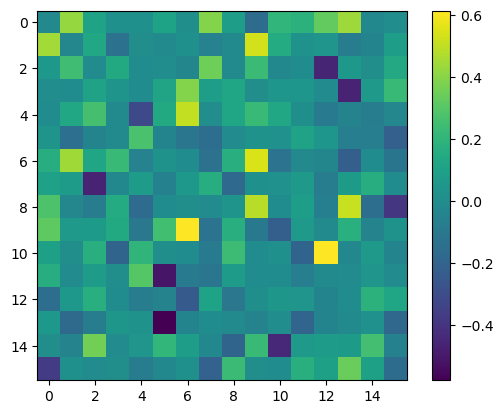

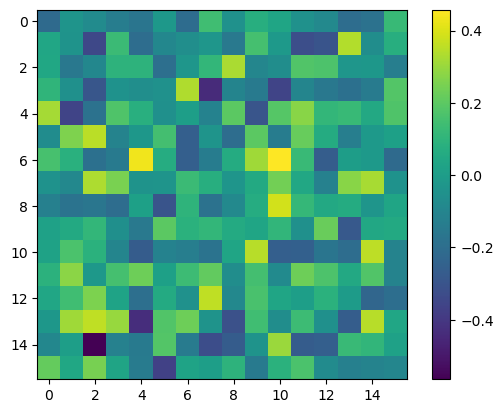

In [44]:
"""
Everything below this is just random stuff I wrote in the process of making this

"""


#print(xdot, temp)
latent_im = X_klatent_post.reshape(16,16).detach().cpu().numpy()
gt_latent_im = Y_gt.reshape(16,16).detach().cpu().numpy()
with torch.no_grad():
    xdot, _, _, _ = vio.forward(_, X_klatent_post, _, X_klatent_post)
    print(xdot)
    print(temp)
    ukf_l = d_loss(id+i3+i4+1, xdot, 0,0,0,loss_metric).detach().cpu().numpy()
    gt_l = d_loss(id+i3+i4+1, temp, 0, 0, 0, loss_metric).clone().detach().cpu().numpy()
    print(ukf_l, gt_l)
    

#print(ukf_t.R_kp)
print()
#print(ukf_t.R_kl)

plt.figure(1)
plt.imshow((latent_im-gt_latent_im))
plt.colorbar()

plt.figure(2)
plt.imshow(gt_latent_im)
plt.colorbar(cmap=gt_latent_im)


In [11]:

print(X_kpose_post.shape, X_klatent_post.shape, P_kp_post.shape, P_kl_post.shape, K_kp.shape, K_kl.shape)




torch.Size([18]) torch.Size([256]) torch.Size([1, 18, 18]) torch.Size([1, 1, 256, 256]) torch.Size([1, 18, 18]) torch.Size([1, 256, 256])


In [12]:

print('physical',t_hat.shape, sigma_Y_t.shape)
print('latent', sigma_Y_l_t.permute(2,0,3,1).shape)
print(x.shape)


physical torch.Size([1, 1, 36, 18]) torch.Size([1, 1, 36, 18])
latent torch.Size([512, 1, 256, 1])
torch.Size([512, 2, 3])


In [13]:
print(p_inp.min())

print(P_xxl_prior_t.min())

print(P_xx_prior_t.max())

tensor(-0.0703, device='cuda:0')
tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3263, device='cuda:0', grad_fn=<MaxBackward1>)


In [14]:



image = torch.zeros((1,1,448,448))
latent_prior = torch.zeros((1,512,28,28))
latent_history = torch.zeros((3,512,28,28))

loss_metric = nn.MSELoss() # nn.L1Loss()
dt = 0.05

id_list = np.arange(600)
id_list = np.append(id_list,(np.arange(200)+900))


ukf_train = False
odom_train = False
batch_size = 10
loss_odom_sum = 0

l_avg = 0
for i3 in range(5):
    np.random.shuffle(id_list)
    l_avg = 0
    for i1 in range(1):#len(id_list)): # as of right now I don't need it to loop cause its just embedding the first 4 states and predictiing a single timestep 
        id = id_list[i1]
        for i2 in range(3):
            latent_history[i2] = latent_precomp[id+i2].detach().cpu() # ((latent_precomp[id+i2] - l_min)/(l_max-l_min)).detach().cpu()
            

        x_hat_ = torch.zeros(1,1,2,18).cuda()
        #x = gt_x_[id+i2].cuda() #x_hat_[0,0,0:2,0:3].cuda()
        #o = gt_o_[id+i2].cuda() #x_hat_[0,0,0:2,9:12].cuda()
        

        """
        Perform everyhting up to measurement step
            1. collect latent vector at time k-1
            2. predict state at time k

        """
        if ukf_train:
            latent_Y_odom = latent_history
            r, p, v, a = vio.encode(latent_Y_odom.reshape(-1,28,28).cuda())#o, t = vio.encode(latent_history.reshape(-1,28,28)) # latent space from time k-1 to k-4
            p_inp = p.reshape(1,1,256,1).cuda() # just a bunch of unsqueezes really
            #t = t.reshape(1,1,256,1)    
            
            x_vehicle = vehicle_state_embed(id+3, dt).cuda()
            print(x_vehicle.device)
            P_xx_prior_t = ukf_t.P_init_s
            P_xxl_prior_t = ukf_t.P_init_l
            
            #P_xx_prior_o = ukf_o.P_init_s
            #P_xxl_prior_o = ukf_o.P_init_l
            ukf_t.latent_history = latent_history
            ukf_t.vehicle_history = 
            t_hat, sigma_Y_t, P_xx_t, latent_hat_t, sigma_Y_l_t, P_xxl_t, l_hat_mean_t, t_hat_mean = ukf_t.predictor(p_inp, x_vehicle, dt, P_xx_prior_t, P_xxl_prior_t)
            #o_hat, sigma_Y_o, P_xx_o, latent_hat_o, sigma_Y_l_o, P_xxl_o, l_hat_mean_o, o_hat_mean = ukf_o.predictor(o, x_vehicle, dt, P_xx_prior_o, P_xxl_prior_o)


        """
        Collect measurements at time k
            1. get new latent space from depth network for frame k
            2. get new odom latenet space for time k
            3. get odometry "measurement" (prediction) for time k
            4. integrate outputs with dynamic model to predict current x, p, xdot, pdot

        """
        #latent_k = latent_precomp[id_list[i1] + 4].unsqueeze(0)
        #latent_Y_odom = torch.concat((latent_k, latent_history[:-1,:,:,:]),dim=0) # latent space from time k to k-3
        latent_Y_odom = latent_history #latent_precomp[id_list[i1] + i2].detach().cpu()
        #print(latent_Y_odom.shape)
        r, p, v, a = vio.encode(latent_Y_odom.reshape(-1,28,28).cuda())
        dx = r
        do = p
        ddx = v
        ddo = a
        
        
        
        #print('r, p, v, a', r.shape, p.shape, v.shape, a.shape)
        xdot,xdotdot,pdot,pdotdot = vio.forward(r, p, v, a)
        #print('dx,ddx, do,ddo', xdot.shape, xdotdot.shape, pdot.shape, pdotdot.shape)
        
        loss_odom = d_loss(id, xdot, 0, 0, 0, loss_metric) #pdot.flatten(), xdotdot.flatten(), pdotdot.flatten(), loss_metric)
        
        
        if ukf_train:
            latent_Y_t = p # Set the "measurement" as the actual latent space for translation and orientation branches of the odometry network
            #latent_Y_o = r
        
        if odom_train:
            #loss_odom, state_Y = integration_loss(x_hat_, xdot,xdotdot,pdot,pdotdot, id + 4, dt, loss_metric)
            loss_dx = 0
            #print(loss_odom)
            loss_odom_sum += loss_odom
            l_avg += loss_odom.clone().detach().cpu().numpy()

            if i1%batch_size == 0 and i1 > 0:
                optim_odom.zero_grad()
                (loss_odom_sum/batch_size).backward()
                optim_odom.step()
                del r
                del p
                del xdot
                del xdotdot
                del pdot
                del pdotdot
                del loss_odom
                del loss_odom_sum
                loss_odom_sum = 0
                #del state_Y
                del x
                del o
                del x_hat_


        """
        Perform ukf update step
        1. update new odom latent space based on dynamic prediction vs truth
        2. predict new odom based on updated rp
        3. make new odom predicitons and backprop loss

        """ 
        if ukf_train:
            XT_post, XT_latent_post, P_kp_post, P_kl_post, K_kp, K_kl = ukf_t.update(t_hat, sigma_Y_t, P_xx_t, state_Y, latent_hat_t, sigma_Y_l_t, P_xxl_t, latent_Y_t)
            #XO_post, XO_latent_post, P_kp_post, P_kl_post, K_kp, K_kl = ukf_o.update(o_hat, sigma_Y_o, P_xx_o, state_Y, latent_hat_o, sigma_Y_l_o, P_xxl_o, latent_Y_o)
            xdot ,_, _, _ = vio.forward(0, XT_latent_post, 0, 0)
            
            #optim_ukf.zero_grad()
            #loss_ukf,_ = integration_loss(x_hat_, xdot,xdotdot,pdot,pdotdot, id, dt, loss_metric)
            #loss_ukf.backward()
            #optim_ukf.step()

        
    #print('Average odom loss epoch',i3+1,':', l_avg / len(id_list))

        

SyntaxError: invalid syntax (3197180577.py, line 52)

In [ ]:

"""
Testing

"""

image = torch.zeros((1,1,448,448))
latent_prior = torch.zeros((1,512,28,28))
latent_history = torch.zeros((3,512,28,28))

loss_metric = nn.MSELoss()
dt = 0.05

id_list = np.arange(400)
np.random.shuffle(id_list)
ukf_train = False
batch_size = 3
loss_odom_sum = 0

x_list = np.zeros((1330,3))
x_dot_list = np.zeros((1330,3))
x_hat_ = torch.zeros(1,1,2,18).cuda()
l_avg = 0
with torch.no_grad():
    for i1 in range(1330): # as of right now I don't need it to loop cause its just embedding the first 4 states and predictiing a single timestep 
        for i2 in range(3):
            latent_history[i2] = latent_precomp[i1 + i2].detach().cpu()


        id = 1 # np.random.randn(1300)
        x_hat_ = torch.zeros(1,1,2,18).cuda()
        x = x_hat_[0,0,0:2,0:3].cuda()
        o = x_hat_[0,0,0:2,9:12].cuda()

        """
        Perform everyhting up to measurement step
            1. collect latent vector at time k-1
            2. predict state at time k

        """
        if ukf_train:
            o, t = vio.encode(latent_history.reshape(-1,28,28)) # latent space from time k-1 to k-4
            o = o.reshape(1,1,256,1) # just a bunch of unsqueezes really
            t = t.reshape(1,1,256,1)    
            #  
            P_xx_prior_t = ukf_t.P_init_s
            P_xxl_prior_t = ukf_t.P_init_l
            P_xx_prior_o = ukf_o.P_init_s
            P_xxl_prior_o = ukf_o.P_init_l

            t_hat, sigma_Y_t, P_xx_t, latent_hat_t, sigma_Y_l_t, P_xxl_t, l_hat_mean_t, t_hat_mean = ukf_t.predictor(o, x_vehicle, dt, P_xx_prior_t, P_xxl_prior_t)
            o_hat, sigma_Y_o, P_xx_o, latent_hat_o, sigma_Y_l_o, P_xxl_o, l_hat_mean_o, o_hat_mean = ukf_o.predictor(t, x_vehicle, dt, P_xx_prior_o, P_xxl_prior_o)
 

        """
        Collect measurements at time k
            1. get new latent space from depth network for frame k
            2. get new odom latenet space for time k
            3. get odometry "measurement" (prediction) for time k
            4. integrate outputs with dynamic model to predict current x, p, xdot, pdot

        """
        latent_k = latent_precomp[i1 + 4].unsqueeze(0)
        latent_Y_odom = latent_history #torch.concat((latent_k, latent_history[:-1,:,:,:]),dim=0) # latent space from time k to k-3
        
        r, p, v, a = vio.encode(latent_Y_odom.reshape(-1,28,28).cuda())
        dx = r
        do = p
        ddx = v
        ddo = a
        #print('r, p, v, a', r.shape, p.shape, v.shape, a.shape)
        xdot,xdotdot,pdot,pdotdot = vio.forward(r, p, v, a)
        
        x_list[i1] = xdot[0].detach().cpu().numpy()
        x_dot_list[i1] = xdot[1].detach().cpu().numpy() - xdot[0].detach().cpu().numpy()
        
        if ukf_train:
            latent_Y_t = p # Set the "measurement" as the actual latent space for translation and orientation branches of the odometry network
            latent_Y_o = r
        
        #loss_odom, state_Y = integration_loss(x_hat_, xdot,xdotdot,pdot,pdotdot, i1, dt, loss_metric)
        #l_avg += loss_odom.clone().detach().cpu().numpy()

        del r
        del p
        del xdot
        del xdotdot
        del pdot
        del pdotdot
       # del loss_odom
        #del state_Y
        del x
        del o
        #del x_hat_


        """
        Perform ukf update step
        1. update new odom latent space based on dynamic prediction vs truth
        2. predict new odom based on updated rp
        3. make new odom predicitons and backprop loss

        """
        if ukf_train:
            XT_post, XT_latent_post, P_kp_post, P_kl_post, K_kp, K_kl = ukf_t.update(t_hat, sigma_Y_t, P_xx_t, state_Y, latent_hat_t, sigma_Y_l_t, P_xxl_t, latent_Y_t)
            XO_post, XO_latent_post, P_kp_post, P_kl_post, K_kp, K_kl = ukf_o.update(o_hat, sigma_Y_o, P_xx_o, state_Y, latent_hat_o, sigma_Y_l_o, P_xxl_o, latent_Y_o)
            xdot,xdotdot,pdot,pdotdot = vio.forward(XO_latent_post, XT_latent_post)

            #optim_ukf.zero_grad()
            loss_ukf,_ = integration_loss(x_hat_, xdot,xdotdot,pdot,pdotdot, id, dt, loss_metric)
            #loss_ukf.backward()
            #optim_ukf.step()

print('done')
        

In [ ]:

axis = np.arange(1330)
plt.plot(axis, x_dot_list)
print(vio.biases_x)


In [ ]:

c = 0
axis = np.arange(1330)
axis2 = np.arange(1337)
print(x_list.shape)
tt = torch.zeros(1330,3)
ttdx = torch.zeros(1330,3)


for i in range(1330):
    x1 = gt_x_[:,i]
    x2 = gt_x_[:,i+1]
    x3 = gt_x_[:,i+2]
    tt[i] = x2-x1
    dx1=(x1-min_dx)/(max_dx-min_dx)
    dx2=(x2-min_dx)/(max_dx-min_dx)
    dx3=(x3-min_dx)/(max_dx-min_dx)
    dddd = ((dx3-dx2) - (dx2-dx1))
    ttdx[i] = (dddd-min_accel)/(max_accel-min_accel)
    
v=1
plt.figure(1)
plt.plot(axis,((tt[:,v]-min_dx[v])/(max_dx[v]-min_dx[v])).numpy(), axis, x_list[:,v]+0.15)
plt.figure(2)
plt.plot(axis, ttdx[:,v], axis, x_dot_list[:,v]+0.15)
print(ttdx.max(), x_dot_list.max())


In [46]:

#PATH = 'vio_size_2' 
#torch.save(vio.state_dict(), PATH)
PATH = 'ukf_dx' 
torch.save(ukf_t.state_dict(), PATH)
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated()/1000000)


336.861696


In [ ]:


print('Average odom loss?', l_avg / 1330)



In [ ]:


"""
Precompute the latent spaces since theyre static 

"""



if 1:
    latent_precomp = torch.zeros((1337,512,28,28), requires_grad=False)
    with torch.no_grad():
        drop = False
        noise = 0
        for i1 in range(len(_im)):
            x = _im[i1].float().cuda().unsqueeze(0).unsqueeze(0)
            o4, o3, o2, o1 = depth.encode( x, drop ) # deep to shallow latent
            L, _o3, _o2 = depth.latent( o4, o3, o2, False, noise)

            latent_precomp[i1,:,:,:] = L






In [ ]:

print('dt', (int(pose_timestamp[int(pt_01[1][1])]) - int(pose_timestamp[int(pt_01[1][0])]))/np.power(10,9))




In [ ]:




kernel = [3, 3, 3, 3, 3, 3]
stride = [1, 1, 1, 1, 1, 1]
padding = [1, 1, 1, 1, 1, 1]
        
kernel_pool = [3, 3, 3, 3]
stride_pool = [2, 2, 2, 2]
padding_pool = [1, 1, 1, 1]

kernel_inv = [2, 2, 2]
stride_inv = [2, 2, 2]
padding_inv = [0, 0, 0]
dim = [1, 64, 128, 256, 512, 1024]

depth = odom.x_net_decomp(dim, kernel, stride, padding, kernel_pool, stride_pool, padding_pool, kernel_inv, stride_inv, padding_inv)

integrator = ukf_.dynamic_model_vehicle()
batch_size = 4
vio = odom.vio_net(batch_size)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

PATH = 'depth_1_07_23' # 'encoder_state_dict_OGRE_stacked_im' 'encoder_state_dict_OGRE_stacked_im' 
depth.load_state_dict(torch.load(PATH, map_location=device))
        
depth.to(device)    
vio = vio.to(device)
integrator.to(device)

l_history = torch.ones(4,4,16) #torch.ones(4,8,16)
numVstates = 18
v_history = torch.rand((4,1,numVstates)) #.repeat(1,8,1)
numLfeatures = 128 # latent_depth//4 #256

ukf = ukf_.UKF(numLfeatures, numVstates, l_history, v_history)
    
#from itertools import chain
    
#optimizer = optim.NAdam(chain(vio.parameters(), xnet.parameters()), lr = 0.0001, betas = (0.9,0.99))
optimizer = optim.NAdam(vio.parameters(), lr = 0.0001, betas = (0.9,0.99))
optimizer_depth = optim.NAdam(xnet.parameters(), lr = 0.001, betas = (0.9,0.99))

dt = (int(pose_timestamp[int(pt_01[1][1])]) - int(pose_timestamp[int(pt_01[1][0])]))/np.power(10,9)



In [ ]:

"""

Primary odometry training block

"""

epochs = 10
batch_size = 3 # Note: really the length of image the sequence, so 1 < batch_size < inf
index = np.arange(450)
t = torch.zeros(6)
pc_xyz_pre = torch.zeros(batch_size,3,56,56)
loss = 0
scale_ms = 1
scale_3d = 0.2
l_avg = 0
camfer_ish = False
alt_loss = False

print('Training for',epochs,'epochs with a range of',len(index),'samples using',device)

for i1 in range(epochs):
    random.shuffle(index)
    count = 0
    for i2 in range(len(index)//int(batch_size)):
            
            for i3 in range(int(batch_size)): # collect data in batches of batch_size
                idx = index[i2 * int(batch_size) + i3]
                inp = _im[idx].unsqueeze(0).float().cuda()

                for i4 in range(6):
                        #t[i4] = _gt[i4][idx+1] - _gt[i4][idx]
                        t[i4] = t_norm[idx][i4] # Wait, t_norm is the precomputed rot+translations...
                #inp = gray.get_gray(inp.cuda()).squeeze().unsqueeze(0) / 256.0

                if i3 == 0:
                    op_batch = t.unsqueeze(0)
                    inp_batch = inp.unsqueeze(0)
                else:
                    if i3 < batch_size - 1:
                        op_batch = torch.concat((op_batch, t.unsqueeze(0))) # list of odometry translations and rotations
                    inp_batch = torch.concat((inp_batch, inp.unsqueeze(0))) # array of input images
                    
                    
            o4, o3, o2, _ = x_net.encode(inp_batch,False)
            latent, _o3, _o2 = x_net.latent( o4, o3, o2, False,0)
            latent = latent.reshape(int(latent.shape[1]*batch_size), latent.shape[2], latent.shape[2])
            pose_pred, rot_pred = vio.forward(latent) # for now just do one pair of images

            #rot_pred = rot_pred*0
            #odom_pred = torch.concat((pose_pred.reshape(batch_size-1,-1).unsqueeze(0), rot_pred.reshape(batch_size-1,-1).unsqueeze(0)), dim=2)
            odom_pred = torch.concat((pose_pred.unsqueeze(0), rot_pred.unsqueeze(0)), dim=1)
           

            optimizer.zero_grad()
            loss.backward()
            l_avg += loss.clone().detach().cpu().numpy()
            count += 1
            optimizer.step()

            del inp
            del op_batch
            del inp_batch
            del o2
            del o3
            del o4
            del _o2
            del _o3
            #del depth_pred
            del latent
            del odom_pred
            #del loss_odom
            del loss
            loss = 0
            del t
            t = torch.zeros(6)
    if i1%2 == 0:
        print('Avg loss for epoch',i1+1,' is:',l_avg/count)
    l_avg = 0
    count = 0



In [ ]:


if 0:


"""

Loop: requires 4 latenet spaces for embedding, and the next 4 latenet spaces for prediciton.

"""


for i1 in range(1):
    
    if update:
        X_kpose_post, X_klatent_post, P_kp_post, P_kl_post, K_kp, K_kl
        latent_K_prior = latent_Y
        x_vehicle = X_kpose_post # Maybe use gt_Y?
        P_xx_prior = P_xx_post
        P_xxl_prior = P_xxl_post
    
    # squeeze latent space to ukf size (128). This is from image at time K-1
    l_squeezed = se.encode(latent_K_prior)
    # Perform everything up to measurement step
    p_hat, sigma_Y_p, P_xx, latent_hat, sigma_Y_l, P_xxl, l_hat_mean, p_hat_mean = ukf.predictor(l_squeezed, x_vehicle, dt, P_xx_prior, P_xxl_prior)

    
    
    
    # Collect measurements at time K. This is basically the traditional training routine
    latent_Y = depth.latent(depth.encode(image_K), 0) # squeeze latent space to ukf size (128). This is from image at time K
    xdot,xdotdot,pdot,pdotdot = vio(latent_Y_x4) # Collect odometry "measurement" for time K. This takes in a x4 latenet space from time [K:k-3]
    
    x = x_hat_[0,0,0,0:3]
    p = x_hat_[0,0,0,9:12]
    
    pred = torch.concat((x,xdot,xdotdot,p,pdot,pdotdot), dim=0).reshape(1,1,1,18)
    Y_hat_ = integrator(pred, 0.1)
    
    optimizer_odom.zero_grad()
    loss_odom = loss_metric(state_Y, gt_Y)
    loss_odom.backward()
    optimizer_odom.step()
    
    
    
    
    # Perform ukf update step
    latent_Y_squeezed = se.encode(latent_Y) # Encode actual latent space for update step
    X_kpose_post, X_klatent_post, P_xx_post, P_xxl_post, K_kp, K_kl = ukf.update(p_hat, sigma_Y_p, P_xx, state_Y, latent_hat, sigma_Y_l, P_xxl, latent_Y)
    latenet_post = se.decode(X_klatent_post, latent_) # perform excite based on ukf update remapping to original latenet space (512)
    latent_Y_x4_training = torch.concat((latent_Y_x4[1:3,:,:],latent_post), dim=0) # for training substitute with posteriori state
    state_Y_training = vio(latent_Y_x4_training)
    
    
    x = x_hat_[0,0,0:2,0:3]
    p = x_hat_[0,0,0:2,9:12]
    pred = torch.concat((x,xdot,xdotdot,p,pdot,pdotdot), dim=1).reshape(1,2,1,18)
    x_hat_1 = integrator(pred[0,0,0,:].reshape(1,1,1,18), dt)
    x_2 = pred[0,1,0,:]
    m = (x_2 + x_hat_1)/2
    pred[0,1,0,3:9] = m[0,0,0,3:9]
    pred[0,1,0,12:18] = m[0,0,0,12:18]
    x_hat_2 = integrator(pred[0,1,0,:].reshape(1,1,1,18), dt)
    x_hat_ = torch.concat((x_hat_1, x_hat_2), dim=2)
    x_hat_x = x_hat_2[0,0,0,0:6]
    x_hat_o = x_hat_2[0,0,0,9:12]
    gt_Y_x = torch.concat((gt_x_[:,id]-gt_x_[:,id-1], gt_xdot_[:,id]-gt_xdot_[:,id-1]))
    gt_Y_o = gt_o_[:,id] - gt_o_[:,id-1]
    
    # Back prop
    optimizer_ukf.zero_grad()
    loss_attn = loss_metric(x_hat_x, gt_Y_x) + loss_metric_o(x_hat_o, gt_Y_o)
    loss_attn.backward()
    optimizer_ukf.step()





